<style>
.box{
    border-radius: 5px;
    padding: 20px;
    width: 100%;
    border: 1px solid #022b37;
    margin-bottom: 10px;
    margin-top: 50px;
}

.quarto-title-banner {
color: #000000 !important;
border-bottom: 1px solid #022b37 !important;
}

pre{
    background-color: #000000 !important;
    opacity: 0.85;
}

body{
    background-color: #ffffff !important;
}
.sidebar nav[role="doc-toc"] ul > li > a{
    color: #464646 !important;
}

.sidebar nav[role="doc-toc"] ul > li > a.active{
    color: #000000 !important;
    border-color:  #000000 !important;
    font-size: calc(var(--bs-body-font-size)*1.05) !important;);
}

.cell-output {
    background-color: #f0f2f4!important;
    padding: 20px;
    border-radius: 5px;
    border: 1px solid #eef0f3;
    margin-bottom: 30px;
}
.cell-output pre{
    background-color: #f0f2f4!important;
    opacity: 1;
}

img{
    border-radius: 5px;
}

/*
.cell-output {
    background-color: #000000!important;
    opacity: 0.85;
    color: #ffffff !important;
    padding: 20px;
    border-radius: 5px;
    border: 1px solid #eef0f3;
}
*/
</style>


---

Loading the data and required packages...

In [ ]:
#install.packages ("pls")
#install.packages("yardstick")
#install.packages("dplyr", version = "1.1.0")
#install.packages("moments")
#install.packages ("valmetrics")


library (pls)
library(yardstick)
library(IRdisplay)
library(pastecs) #--> conflicts with terra's extract function, so this has to load before loading terra
library (terra)
library(moments)
library(valmetrics)

In [2]:
# set working directory based on the git repository
repo_dir<-system("git rev-parse --show-toplevel", intern=TRUE)
current_ex="/06_PLSreg"
setwd(paste(repo_dir,current_ex, sep=""))
#getwd()


#load the training data
enmap <- rast ("enmap_ammersee.tif")
calpoints <- read.table ("calpoints.txt", header=T, dec=".")
valpoints <- read.table ("valpoints.txt", header=T, dec=".")
LAI <- calpoints[,1]
wl <- read.table ("enmap_wl.txt")[,1] # the wavelengths

#set seed for the models
set.seed(42)

In [10]:
plotRGB (enmap, 60, 45, 30, stretch="lin")
points (calpoints[,2:3], cex=LAI / 6 + 0.3, lwd=2)

<div class="box">
## Q6.1

Use your expert knowledge on visual image interpretation. Which vegetation type (deciduous 
forest, needle­leaf forest, grassland) features the highest LAI values?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

The highest leaf area index (LAI) values looking at the calibration points are found in the deciduous forest, followed by the grasslands and then needle-leaf forest areas. Although needle-leaf forests and grasslands both show partly higher and partly lower LAI values than the respective other vegetation type, the deciduous forest areas show the highest LAI values overall.

---

<br>


<div class="box">
## Q6.2

PLSR model optimization is known to be affected by a skewed distribution of the response variable.  How  are  the  LAI  values  statistically  distributed?  Perform  a  test,  visualization  or  suitable quantification  to  assess  whether  you  are  going  to  face  problems  (or  have  to  think  about  some  kind  of transformation).
</div>

In [5]:
#PLSR model optimization is known to be affected by a skewed distribution of the response variable.  How  are  the  LAI  values  statistically  distributed?  Perform  a  test,  visualization  or  suitable quantification  to  assess  whether  you  are  going  to  face  problems  (or  have  to  think  about  some  kind  of transformation).
hist (LAI, breaks=20, col="grey", border="white", xlab="LAI", main="Histogram of LAI values", freq=FALSE)
lines(density(LAI), col = "#ee6c4d", lwd = 2)

display(round(as.data.frame(stat.desc(LAI)),4))

print(paste("Skewness of LAI:",round(skewness(LAI),4)))

stat.desc(LAI)
nbr.val       65.0000      
nbr.null       1.0000      
nbr.na         0.0000      
min            0.0000      
max            9.0024      
range          9.0024      
sum          261.2558      
median         3.5355      
mean           4.0193      
SE.mean        0.3255      
CI.mean.0.95   0.6502      
var            6.8849      
std.dev        2.6239      
coef.var       0.6528

[1] "Skewness of LAI: 0.4752"


<span style="color:#fc8acc">
**Answer:**
</span>

Plotting the density of the LAI values shows that there is more than one peak in the distribution (one global peak, two local peaks at the end of the range). The distribution is also right-skewed, as the mean is higher than the median, which can also be recognized in the negative skewness value. Both could be problematic for the PLSR model optimization.

---

<br>


<div class="box">
## Q6.3

Take a look at the wavelength information. Is there anything strange about it (Of course, there is. 
But what?)
</div>

In [6]:
## get the differences between the wls
wl_diff <- diff (wl)

## group wldiff by ranges
wl_diff_group <- cut (wl_diff, breaks=c(0, 5,10,15))
#wl_diff_group

#group frequencies
table (wl_diff_group)


wl_diff_group
  (0,5]  (5,10] (10,15] 
     15     146      81 

<span style="color:#fc8acc">
**Answer:**
</span>

The differences between the different wavelengths are not equal. There is 15 values with a distance of under 5nm, 146 between 5 and 10nm and 81 between 10 and 15nm. In general, the intervals are never equal as the wavelength are given with second decimals. The differences can be due to special characteristics in certain wavelength ranges for the detection and analysis of the earth's surface, as well as certain atmospheric conditions, which make a larger wavelength range in certain spectral domains necessary.

---

<br>


Extracting the calibration spectra...

In [7]:
names (enmap) <- paste0 ("nm", wl)
calref <- extract (enmap, calpoints[, 2:3], ID=F)

In [6]:
#dev.off()
gc <- colorRampPalette (c ("#784421", "#00FF00", "#008000"))
plot (wl[-c (90:99)], calref[1, -c (90:99)] / 100, type="l", ylim=c (0, 50), 
      col=gc(10)[round (LAI[1]) + 1], xlab ="Wavelength / nm", 
      ylab="Reflectance / %")
for (i in 2:65)
  lines (wl[-c (90:99)], calref[i, -c (90:99)] / 100, 
         col=gc (10)[round (LAI[i]) + 1])
legend ("topleft", legend=0:9, col=gc(10), lty=1, lwd=2)

<div class="box">
## Q6.4

According to your visual examination ­ in which spectral regions is the LAI value related to the 
reflectance?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

Overall the reflectance is related to the LAI value in the whole spectrum and the curves are similar in their peaks and valleys. However, the relation is especially visible in the green reflectance spectrum between 500 and 600 nm (Chlorophyll absorbs less, green peak) and in the near infrared spectrum (700-1300nm) (cellular structure and leaf internal structure) and the shortwave infrared spectrum (1300-2500nm).

---

<br>


<div class="box">
## Q6.5

Which cross­validation methods are available for plsr() or the plsr implementation you are using?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

For the plsr() function of the pls package, the options for the "validation" parameter are "none", "CV" and "LOO". 
"CV" performs cross-validation with the number of segments specified by the "segments" parameter.
"LOO" performs leave-one-out cross-validation.

---

<br>


Assessing the stability of the regression coefficient across the different cross-validation folds using jacknife=T... 

In [8]:
caldat <- data.frame (LAI, calref)
plsmod <- plsr (LAI~., data=caldat, val="CV", jackknife=T, scale=T)

<div class="box">
## Q6.6

What happens if we refrain from standardizing the bands? Which bands would automatically get a higher importance in the model?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

If refraining from standardizing the bands, the bands with larger scales, so higher absolute values or larger ranges, might dominate the model as they will have a higher variance and therefore a higher importance in the model. The near infrared and the short wavelength infrared range would have a higher influence on the result.

---

<br>


Consult the RMSE values for all candidate models (to identify the number of LVs that lead to the best fitting model)...

In [9]:
rmse <- RMSEP (plsmod, "all")
rms <- rmse$val[1:2,,-1]
colnames (rms) <- c (1:ncol (rms))
rownames (rms) <- c ("RMSEcal", "RMSEval")

Plot the RSME values as barplots...

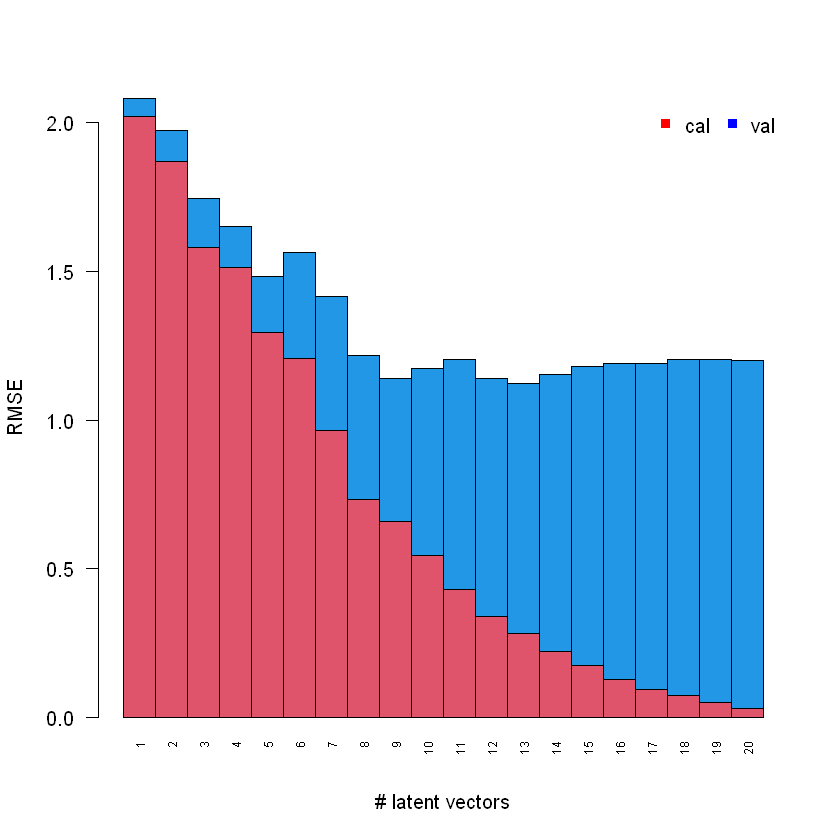

In [10]:
barplot(rms[2,1:20], space=0, col=4, ylim=c (0, max (rms[2,])), las=2, 
        cex.names=0.6, xlab="# latent vectors", ylab="RMSE")
barplot(rms[1,1:20], space=0, col=2, add=T, axes=F, axisnames=F)
legend  ("topright",  legend=c  ("cal",  "val"),  pch=15,  col=c  ('#FF0000', 
'#0000FF'), bty="n", horiz=T)

<div class="box">
## Q6.7

Why is the RMSE in calibration (displayed in red) decreasing monotonically while the RMSE in validation (blue) shows a more complex behavior? Which number of LVs leads to the smallest RMSE in cross­validation?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

The RMSE in calibration is decreasing monotonically as the model is fitted to the calibration data and therefore the RMSE is always smaller than the previous one. The RMSE in validation is more complex as the model is fitted to the calibration data and then validated on the validation data. Therefore, the RMSE in validation is not always smaller than the previous one. The number of LVs that leads to the smallest RMSE in cross-validation is 13.

---

<br>


Assigning the number of LVs leading to the smallest RMSE...


In [11]:
nlv <-9 ## Change the number if not appropriate

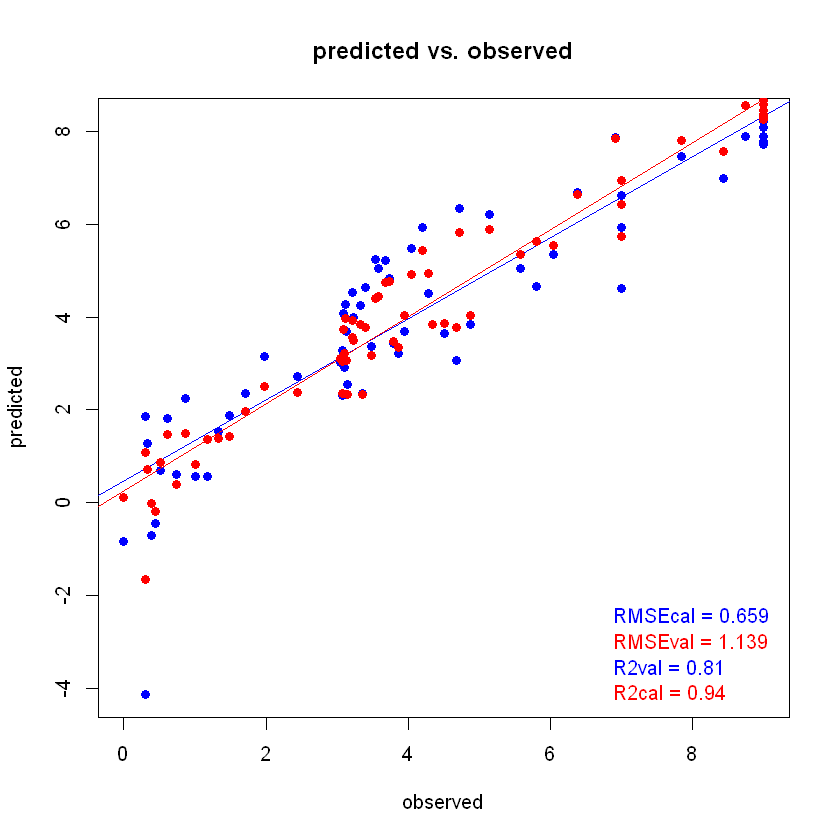

In [12]:
fit.val <- plsmod$validation$pred[,,nlv]
fit.cal <- plsmod$fitted.values[,,nlv]
plot (LAI, fit.val, xlab="observed", ylab="predicted", pch=19, 
      col='#0000FF', main="predicted vs. observed")
pred.obs.val <- lm (fit.val~LAI)
abline (pred.obs.val, col='#0000FF')
points (LAI, fit.cal, pch=19, col='#FF0000')
pred.obs.cal <- lm (fit.cal~LAI)
abline (pred.obs.cal, col='#FF0000')
leg <- paste (c ("RMSEcal", "RMSEval", "R2val", "R2cal"), '=',
               c (round(rms[,nlv],3), round (summary (pred.obs.val)$r.squared, 
     2), round (summary (pred.obs.cal)$r.squared, 2)))
legend  ("bottomright",  legend=leg,  text.col=c  ('#0000FF',  '#FF0000',  '#0000FF', 
'#FF0000'), bty="n")

Check the regression coefficients...

In [13]:
reg.coef <- coef (plsmod, ncomp=nlv)
p  <- 0.1  ##  define  the  threshold  for  the  level  of  significance;  adjust,  if necessary
jt <- suppressWarnings (jack.test (plsmod, ncomp=nlv))$pvalues
sig <- jt<p

In [14]:
plot (wl, reg.coef, type="h",xlab="Wavelength / nm", ylab="Coefficient")
points (wl, reg.coef, pch=c (1, 19)[sig+1])
legend ("topleft", legend=paste0 (c ('p<', 'p>='), p), pch=c (19, 1), bty="n")

<div class="box">
## Q6.8

Which spectral bands feature a high influence (i.e., a high absolute value of the regression coefficient)? Is this selection in line with your visual interpretation of the spectra?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

Especially the bands between 500 and 600 nm, the bands between 750 and 1300 nm and the bands between 1600 and 1750 nm feature a high influence. This is in line with the visual interpretation of the spectra as the reflectance is related to the LAI value in these spectral regions as described in Q6.4. In general those are vegetation sensitive bands that are indicators of vegetation health and chlorophyll content (500-600nm), plant structure (leaf structure) and water content (750-1300nm) and water stress in vegetation (1600-1750nm).

---

<br>


Optimizing the model through backward­selection of spectral bands...

In [15]:
wl2 <- wl[sig]
enmap2 <- subset (enmap, (1:244)[sig==F])
calref2 <- extract (enmap2, calpoints[,2:3], ID=F)
caldat2 <- data.frame (LAI, calref2)

Based on this subset, we build a new model, select the number of LVs to be included and evaluate the model performance...

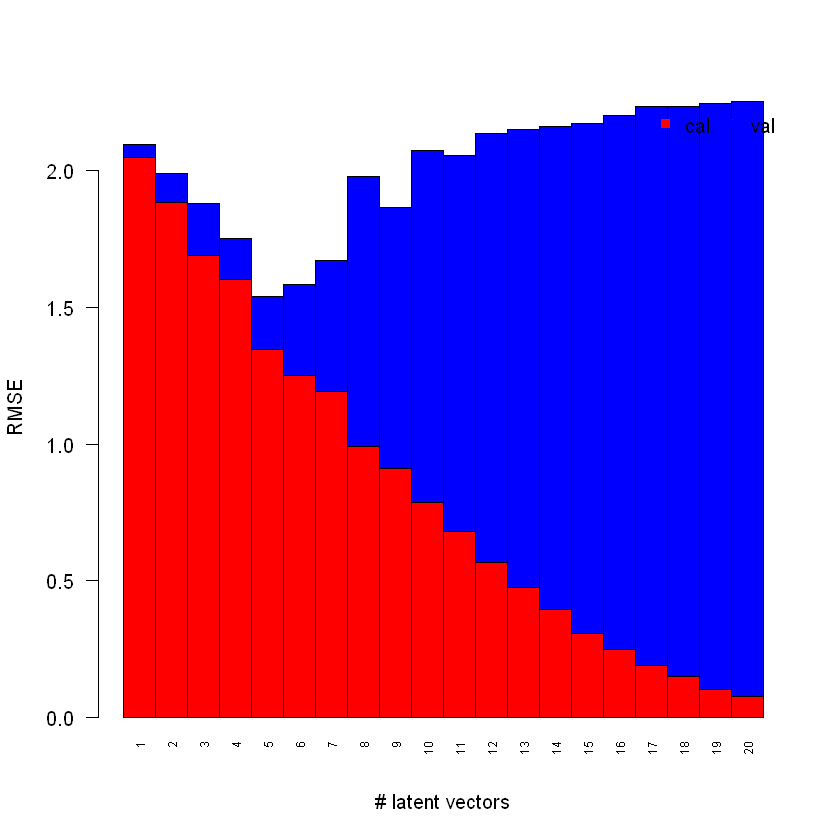

In [16]:
plsmod2 <- plsr (LAI~., data=caldat2, val="CV", jackknife=T, scale=T)
rmse2 <- RMSEP (plsmod2, "all")
rms2 <- rmse2$val[1:2,,-1]
colnames (rms2) <- c (1:ncol (rms2))
rownames (rms2) <- c ("RMSEcal", "RMSEval")
barplot(rms2[2,1:20], space=0, col='#0000FF', ylim=c (0, max (rms2[2,])),
  las=2, cex.names=0.6, xlab="# latent vectors", ylab="RMSE")
barplot(rms2[1,1:20], space=0, col='#FF0000', add=T, axes=F, axisnames=F)
legend ("topright", legend=c ("cal", "val"), pch=15, col=c ('#FF0000', 
'#0000FF'), bty="n", horiz=T)
nlv <- 11 ## Change the number if not appropriate
fit.val2 <- plsmod2$validation$pred[,,nlv]
fit.cal2 <- plsmod2$fitted.values[,,nlv]
plot (LAI, fit.val2, xlab="observed", ylab="predicted", pch=19, 

      col='#0000FF', main="predicted vs. observed")

pred.obs.val <- lm (fit.val2~LAI)
abline (pred.obs.val, col='#0000FF')
points (LAI, fit.cal2, pch=19, col='#FF0000')
pred.obs.cal <- lm (fit.cal2~LAI)
abline (pred.obs.cal, col='#FF0000')
leg <- paste (c ("RMSEcal", "RMSEval", "R2val", "R2cal"), '=',
              c (round (rms2[,nlv], 3), round (summary (pred.obs.val)$r.squared,
                 2), round (summary (pred.obs.cal)$r.squared, 2)))
legend  ("bottomright",  legend=leg,  text.col=c  ('#0000FF',  '#FF0000',  '#0000FF', 
'#FF0000'), bty="n")

<div class="box">
## Q6.9:

Compare the model fit to the results of the first model. How did RMSE and R2 change?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

<br>

| Model | RMSEcal | RMSEval | R2cal | R2val |
|-------|---------|---------|-------|-------|
| First | 0.659   | 1.139   | 0.81  | 0.94  |
| Optimized | 0.682   | 1.969   | 0.54  | 0.93  |

The RMSE of the optimized model are higher than the RMSE of the first model. However, the R2 of the first model is higher than the R2 of the optimized model. The higher RMSE indicates a decrease in precision. The lower R2 values suggest a decrease in the model's ability to explain the variance in the data, indicating a decrease in generalization.

It appears, that the optimized model sacrifices some precision and generalization compared to the first model, which might indicate that the optimization process may not have improved the overall performance of the model. The reason for this may be the multiple peaks in the distribution of LAI values and the right skewness of the distribution, which have a negative impact on the performance of the applied PLSR method.

---

<br>


Mapping the LAI distribution...

In [17]:
pixval <- values (enmap)
mapvalues <- predict (plsmod, pixval,ncomp=nlv)
map <- subset (enmap, 1)
values (map) <- mapvalues

Plot with color gradient...

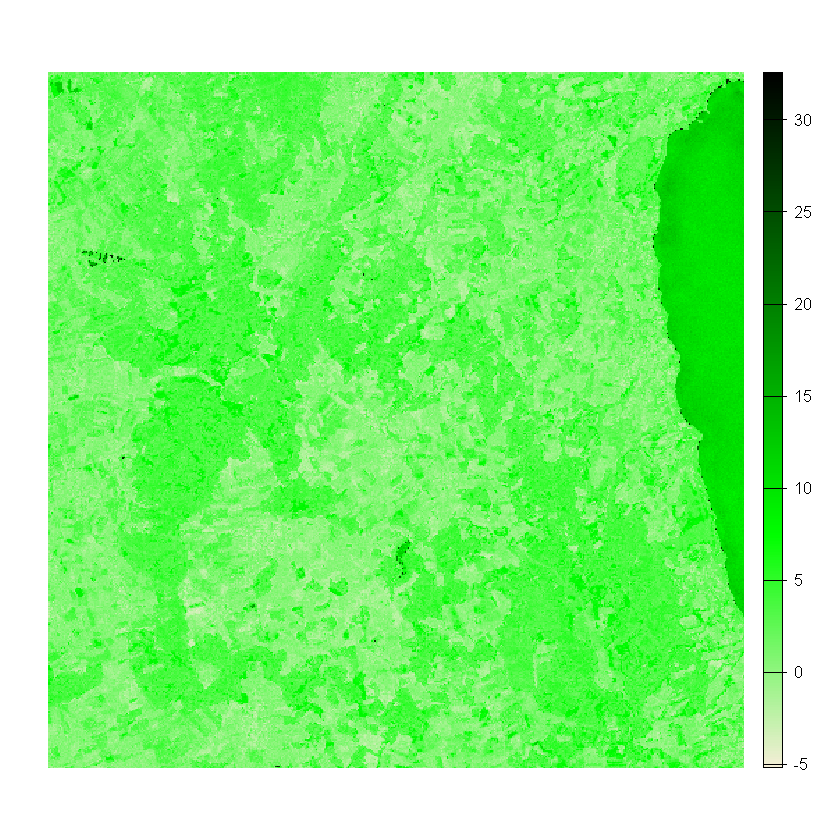

In [18]:
cl <- colorRampPalette (c ("#F4EED7", "#00FF00", "#008000", "#000000"))
plot (map, col=cl (255), axes=F)

Mask  separating  vegetation  from  non­vegetation derived  from  the  Normalized  Difference Vegetation  Index  (NDVI)...

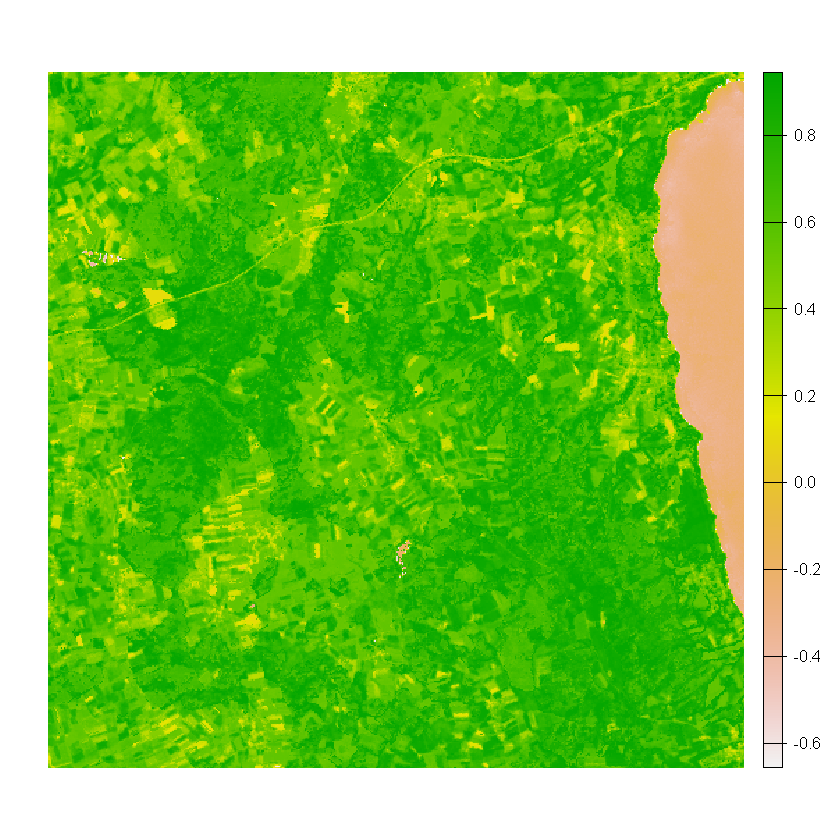

In [19]:
ndvi <- (enmap[[65]] - enmap[[47]]) / (enmap[[65]] + enmap[[47]])
plot (ndvi, axes=F)

Thresholding  (NDVI  >  0)  converts  the  NDVI  layer  into  a  binary  mask  (NA  /  1)  that  is  subsequently  applied 
multiplicatively to the LAI layer...

In [20]:
ndvi.mask <- classify (ndvi, matrix (c (-Inf, 0, NA, 0, Inf, 1), 2, 3,
                         byrow=T))
map2 <- map * ndvi.mask
plot (map2, col=cl (255), axes=F)

Remove pixels exceeding the calibration range...

In [21]:
map2 <- classify (map2, matrix (c (-Inf, 0, NA, 9, Inf, NA), 2, 3, byrow=T))
plot (map2, col=cl (255), axes=F)

Accuracy assessment...

In [23]:
predval <- extract (map, valpoints[,2:3])

#predval <- unlist(predval)
par (pin=c (3, 3))
plot (valpoints[,1], predval$nm423.71, xlim=c (0, 9), ylim=c (0, 9), xlab="Observed LAI",
      ylab="Predicted LAI")
abline (0, 1)
vm <- lm (predval$nm423.71~valpoints[,1])
abline (vm, lty=2)
text (0, 8, paste0 ("R2val=", round (summary (vm)$r.squared, 2)), pos=4)
rmse <- sqrt(mean((predval$nm423.71-valpoints[,1])^2))
text (0, 7, paste0 ("RMSE=", round (rmse, 2)), pos=4)

<div class="box">
## Q6.10:

Compare the R2 and RMSE of the independent validation to the reults of the cross­validation. Do they differ? If yes, can you guess why?
</div>

<span style="color:#fc8acc">
**Answer:**
</span>
<br>
The RMSE value is below the RMSE of the optimized model but above that of the first model. The R² value is lower compared to the other two R2 values and suggest a lower ability of the model to explain the variance in the validation data. The difference between the two previous validation results and the validation result is particularly noticeable in the R2 value. The big difference is due to the independence of the second validation dataset (unseen data), which allows a more realistic evaluation and estimation of the model performance.

---

<br>


<div class="box">
## Q6.11:

Search the web for the 'ratio of performance to deviation (RPD)', a measure to interpret the prediction ability of a model. Calculate the RPD for our second model. How do you judge the prediction ability of your LAI model?
</div>

In [25]:
# defining the rpd function manually
sd_ref <- sd(caldat2$LAI) # Calculate the standard deviation of the reference data
rmsep <- sqrt(mean((fit.val2 - caldat2$LAI)^2)) # Calculate the RMSEP
rpd <- sd_ref / rmsep # Calculate the RPD

## manual approach
rpd(fit.val2, caldat2$LAI)

## using valmetrics package
valmetrics::rpd(fit.val2, caldat2$LAI)

[1] 1.414559

[1] 1.414559

<span style="color:#fc8acc">
**Answer:**
</span>
<br>
The RPD value of 1.41 indicate some predictive ability, but its performance is limited. It may be useful in certain applications but may not be considered highly accurate.

---

<br>


<div class="box">
## Q6.12:

Read the paper by Gomez et al. (2008) and post a related question in the discussion forum. Put the answers to all 
eleven problems and the question you have posted in the forum (3 pts) into a single document and upload it to Moodle
</div>

<span style="color:#fc8acc">
**Answer:**
</span>

**Lennart:**

I understand the point to focus on two soil sample types (cropping soils and pasture soils) to reduce the total number of soil samples, but still get the full range of the SOC. But, why was the limit value of 1% SOC selected for the pasture soils? And doesn't the limitation to these two specific agricultural soil classes tend to increase the problems with mixed pixels from other (non-sampled) soil classes?

In addition, the general sampling of the soil samples was not based on a certain parameter (spatial extent or SOC variation). How did they determine the number of samples per soil class?

A stratified (random) sampling approach based on a land cover (agricultural) classification might be useful to improve the quality of the results. This could potentially even reduce some uncertainties with mixed pixels as a pre-processing step.


**Jannes:**

In the discussion part the authors state the drop in accuracy between the different data used may be due to noise and spatial resolution present in Hyperion: 

*"However, we observed the SOC prediction model using Hyperion hyperspectral data was less accurate than that of the AgriSpec spectra resampled to the low spectral resolution similar to that of the Hyperion data. This drop in accuracy may be due to two factors: the noise present in the Hyperion spectra and the Hyperion spatial resolution of 30 m."*

Before they say, that the spectral resolution is not influencing the accuracy of the model:

*"This paper shows that whatever the SOC ranges of the soil samples (between 0.54 and 1%, between 1.08 and 5.1%, or between 0.54 and 5.1%) and whatever the number of soil samples (56, 72 or 146) used in the prediction models, the spectral resolution did not change the accuracy of the model."*

Later on they say EnMap would behave differently than Hyperion with the model naming the spectral resolution as an influencing factor, as well as the spatial resolution of 30m (same as Hyperion) and a better Signal to Noise ratio: 

*"An Environmental Mapping and Analysis Program (EnMAP) satellite will be launched in 2010, with have onboard a hyperspectral sensor which will provide high-spectral resolution observations over the wavelength range from 420 to 2450 nm (Stuffler et al., 2007). The spatial ground sampling distance will be 30 m and the Signal to Noise Ratio of EnMap should be better than that of Hyperion."*

Why do they believe that for EnMap the spectral resolution will be an influencing factor to improve the accuracy? Also, it would be interesting too see how big the influence of the Signal to Noise ratio is over the spatial resolution regarding the accuracy. Can an improved Signal to Noise ratio already account for the feature mixing errors of a lower spatial resolution (as it is the same as Hyperion's)?  




---

<br>
